In [392]:
#from mido import MidiFile
#mid = MidiFile('nama file.mid')
#for i, track in enumerate(mid.tracks):
#    print('Track {}: {}'.format(i, track.name))
#    for message in track:
#        print(message)

In [202]:
# This class handles the storage and manipulation of a markov chain of notes.

from collections import Counter, defaultdict, namedtuple

import random

Note = namedtuple('Note', ['note', 'duration'])

class MarkovChain:

    def __init__(self):
        self.chain = defaultdict(Counter)
        self.sums = defaultdict(int)

    @staticmethod
    def create_from_dict(dict):
        m = MarkovChain()
        # bugged!
        for from_note, to_notes in dict.items():
            for k, v in to_notes.items():
                m.add(from_note, k, v)
        return m

    def _serialize(self, note, duration):
        return Note(note, duration)

    def __str__(self):
        return str(self.get_chain())

    def add(self, from_note, to_note, duration):
        self.chain[from_note][self._serialize(to_note, duration)] += 1
        self.sums[from_note] += 1

    def get_next(self, seed_note):
        if seed_note is None or seed_note not in self.chain:
            random_chain = self.chain[random.choice(list(self.chain.keys()))]
            return random.choice(list(random_chain.keys()))
        next_note_counter = random.randint(0, self.sums[seed_note])
        for note, frequency in self.chain[seed_note].items():
            next_note_counter -= frequency
            if next_note_counter <= 0:
                return note

    def merge(self, other):
        self.sums = defaultdict(int)
        for from_note, to_notes in other.chain.items():
            self.chain[from_note].update(to_notes)
        for from_note, to_notes in self.chain.items():
            self.sums[from_note] = sum(self.chain[from_note].values())

    def get_chain(self):
        return {k: dict(v) for k, v in self.chain.items()}

    def print_as_matrix(self, limit=10):
        columns = []
        for from_note, to_notes in self.chain.items():
            for note in to_notes:
                if note not in columns:
                    columns.append(note)
        _col = lambda string: '{:<8}'.format(string)
        _note = lambda note: '{}:{}'.format(note.note, note.duration)
        out = _col('')
        out += ''.join([_col(_note(note)) for note in columns[:limit]]) + '\n'
        for from_note, to_notes in self.chain.items():
            out += _col(from_note)
            for note in columns[:limit]:
                out += _col(to_notes[note])
            out += '\n'
        print(out)




In [203]:
# This class handles the parsing of a midi file and builds a markov
# chain from it.

import hashlib
import mido
import argparse



class Parser:

    def __init__(self, filename, verbose=False):
        """
        This is the constructor for a Serializer, which will serialize
        a midi given the filename and generate a markov chain of the
        notes in the midi.
        """
        self.filename = filename
        # The tempo is number representing the number of microseconds
        # per beat.
        self.tempo = None
        # The delta time between each midi message is a number that
        # is a number of ticks, which we can convert to beats using
        # ticks_per_beat.
        self.ticks_per_beat = None
        self.markov_chain = MarkovChain()
        self._parse(verbose=verbose)

    def _parse(self, verbose=False):
        """
        This function handles the reading of the midi and chunks the
        notes into sequenced "chords", which are inserted into the
        markov chain.
        """
        midi = mido.MidiFile(self.filename)
        self.ticks_per_beat = midi.ticks_per_beat
        previous_chunk = []
        current_chunk = []
        for track in midi.tracks:
            for message in track:
                if verbose:
                    print(message)
                if message.type == "set_tempo":
                    self.tempo = message.tempo
                elif message.type == "note_on":
                    if message.time == 0:
                        current_chunk.append(message.note)
                    else:
                        self._sequence(previous_chunk,
                                       current_chunk,
                                       message.time)
                        previous_chunk = current_chunk
                        current_chunk = []

    def _sequence(self, previous_chunk, current_chunk, duration):
        """
        Given the previous chunk and the current chunk of notes as well
        as an averaged duration of the current notes, this function
        permutes every combination of the previous notes to the current
        notes and sticks them into the markov chain.
        """
        for n1 in previous_chunk:
            for n2 in current_chunk:
                self.markov_chain.add(
                    n1, n2, self._bucket_duration(duration))

    def _bucket_duration(self, ticks):
        """
        This method takes a tick count and converts it to a time in
        milliseconds, bucketing it to the nearest 250 milliseconds.
        """
        try:
            ms = ((ticks / self.ticks_per_beat) * self.tempo) / 1000
            return int(ms - (ms % 250) + 250)
        except TypeError:
            raise TypeError(
                "Could not read a tempo and ticks_per_beat from midi")

    def get_chain(self):
        return self.markov_chain



In [ ]:
mid = Parser('beethoven_opus10_1.mid')
Hasil = mid.markov_chain

In [204]:
mid2 = Parser('beethoven_opus10_2.mid')
Hasil2 = mid2.markov_chain


In [205]:
mid3 = Parser('beethoven_opus10_2.mid')
Hasil3 = mid3.markov_chain


In [206]:
mid4 = Parser('pathetique_1.mid')
Hasil4 = mid4.markov_chain
mid5 = Parser('pathetique_2.mid')
Hasil5 = mid5.markov_chain
mid6 = Parser('pathetique_3.mid')
Hasil6 = mid6.markov_chain

In [207]:
Hasil.merge(Hasil2)
Hasil.merge(Hasil3)
Hasil.merge(Hasil4)
Hasil.merge(Hasil5)
Hasil.merge(Hasil6)


In [18]:
Hasil.merge(Hasil3)

In [337]:
#!/usr/bin/python
# This class handles the generation of a new song given a markov chain
# containing the note transitions and their frequencies.

from markov_chain import MarkovChain

import random
import mido

class Generator:

    def __init__(self, markov_chain):
        self.markov_chain = markov_chain

    @staticmethod
    def load(markov_chain):
        
        return Generator(markov_chain)

    def _note_to_messages(self, note):
        return [
            mido.Message('note_on', note=note.note, velocity=127,
                         time=0),
            mido.Message('note_off', note=note.note, velocity=0,
                         time=note.duration)
        ]

    def generate(self, filename):
        with mido.midifiles.MidiFile() as midi:
            track = mido.MidiTrack()
            last_note = None
            # Generate a sequence of 100 notes
            for i in range(500):
                new_note = self.markov_chain.get_next(last_note)
                track.extend(self._note_to_messages(new_note))
            midi.tracks.append(track)
            midi.save(filename)

chain = Chopin
Generator.load(chain).generate("Chopin olo")
print('Generated markov chain')

Generated markov chain


In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



In [270]:
#columns = []
#for from_note, to_notes in Hasil.chain.items():
#   for note in to_notes:
#        if note not in columns:
#            columns.append(note)
#_col = lambda string: '{:<8}'.format(string)
#_note = lambda note: '{}:{}'.format(note.note, note.duration)
#out = _col('')
#out += ','.join([_col(_note(note)) for note in columns[:1000]]) + ',\n'
#for from_note, to_notes in Hasil.chain.items():
#    out += _col(from_note)+","
#    for note in columns[:1000]:
#        out += _col(to_notes[note]) +","
#    out += '\n'
#
#print(out)

In [213]:
#test data,only shows up to first 10 note relation (10 columns)
Hasil.print_as_matrix()

        67:250  63:250  75:250  74:250  62:250  72:500  63:500  62:500  65:500  62:1500 
63      59      56      41      3       49      19      21      23      17      6       
67      22      88      5       8       16      35      18      15      42      2       
72      37      24      26      35      5       43      13      4       18      0       
75      4       3       38      75      4       38      7       0       12      0       
79      26      0       17      7       0       33      1       2       2       0       
84      0       0       6       0       0       25      0       0       0       0       
68      39      4       4       2       7       26      24      14      46      0       
65      8       38      2       4       66      20      46      37      69      4       
71      19      3       3       15      13      26      5       7       11      0       
77      1       0       80      34      3       22      1       2       13      0       
74      2       0    

# Using CSV from previous matrix

In [245]:
stock = pd.read_csv('final chain.csv')
stock = stock.set_index('Note')
show = stock.head()
show = show.append(stock.tail())
stock

,67:250,63:250,75:250,74:250,62:250,72:500,63:500,62:500,65:500,62:1500,...,34:4000,46:4000,47:4000,47:2750,52:2250,30:1000,42:1000,45:1000,48:1000,30:500
Note,,,,,,,,,,,,,,,,,,,,,
63,59,56,41,3,49,19,21,23,17,6,...,0,0,0,0,0,0,0,0,0,0
67,22,88,5,8,16,35,18,15,42,2,...,0,0,0,0,0,0,0,0,0,0
72,37,24,26,35,5,43,13,4,18,0,...,0,0,0,0,0,0,0,0,0,0
75,4,3,38,75,4,38,7,0,12,0,...,0,0,0,0,0,0,0,0,0,0
79,26,0,17,7,0,33,1,2,2,0,...,0,0,0,0,0,0,0,0,0,0
84,0,0,6,0,0,25,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68,39,4,4,2,7,26,24,14,46,0,...,0,0,0,0,0,0,0,0,0,0
65,8,38,2,4,66,20,46,37,69,4,...,0,0,0,0,0,0,0,0,0,0
71,19,3,3,15,13,26,5,7,11,0,...,0,0,0,0,0,0,0,0,0,0


In [286]:
chop = Parser('chpn_op27_1.mid')
Chopin = chop.markov_chain
chop = Parser('chpn_op27_2.mid')
Chopin2 = chop.markov_chain
chop = Parser('chpn_op23.mid')
Chopin3 = chop.markov_chain
chop = Parser('chp_op18.mid')
Chopin4 = chop.markov_chain


In [287]:
Chopin.merge(Chopin2)
Chopin.merge(Chopin3)
Chopin.merge(Chopin4)

In [291]:
#Test data
Chopin.print_as_matrix()

        77:3000 77:6000 78:9000 73:2250 69:2250 73:500  85:500  65:4500 64:4500 73:4500 
77      2       2       3       7       3       5       1       1       1       1       
78      0       0       0       3       3       4       3       0       0       0       
76      5       1       0       0       0       9       3       0       0       0       
74      0       0       0       0       0       7       5       0       0       0       
73      0       0       0       0       0       22      11      3       2       4       
72      2       0       0       0       0       12      2       0       0       0       
80      0       0       0       0       0       7       3       0       0       0       
85      0       0       0       0       0       10      9       0       0       0       
75      1       0       0       0       0       9       1       0       0       0       
68      1       0       0       3       0       7       0       0       0       0       
71      3       0    

In [366]:
table = pd.read_csv('chopin mid.csv')
table = table.set_index('Note')

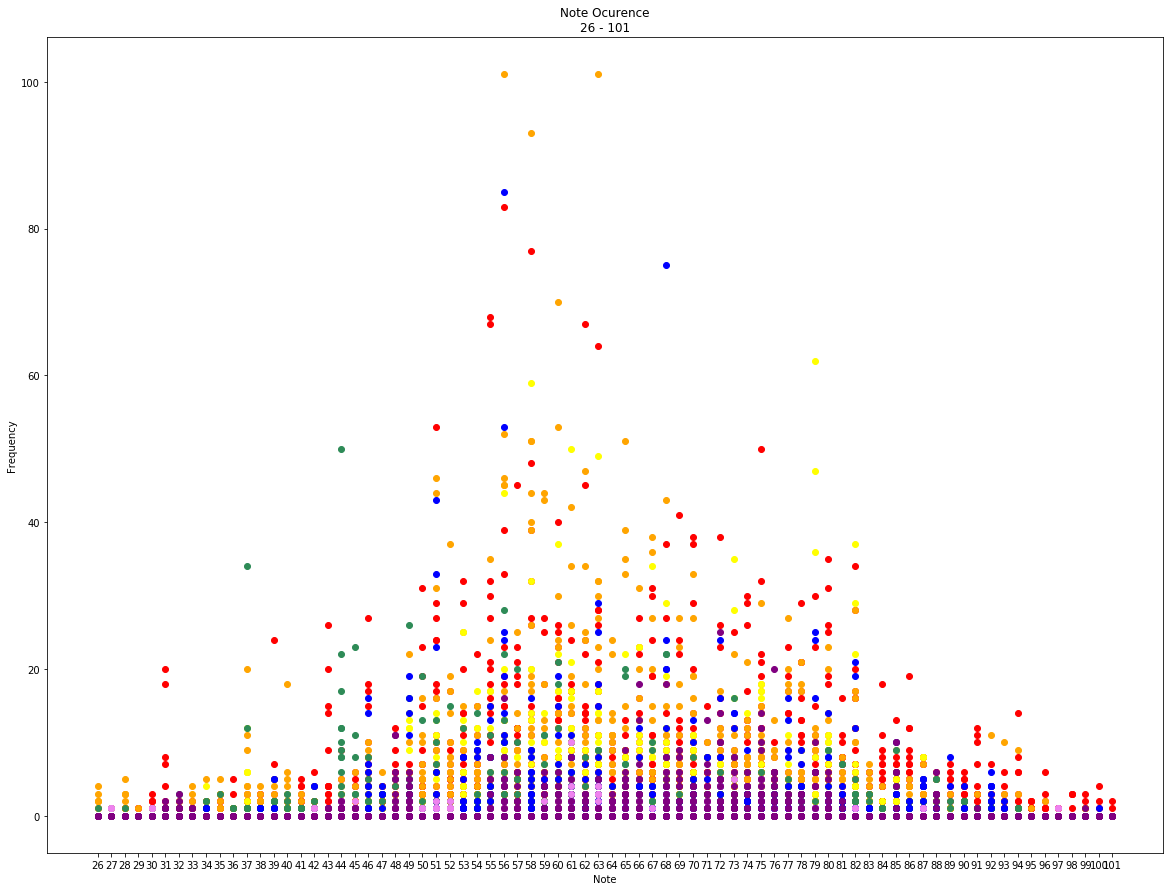

In [414]:
plt.figure(figsize = (20,15))
plt.title('Note Ocurence\n' + str(table.index.min()) + ' - ' + str(table.index.max()))

for i in range(table.index.min(),table.index.max()):
    try:
        plt.plot(table.index, table['{}:250'.format(i)],'o',color="red")
        
        
    except KeyError:
        continue
for i in range(table.index.min(),table.index.max()):
    try: 
        plt.plot(table.index, table['{}:500'.format(i)],'o',color="orange")
           
    except KeyError:
        continue
for i in range(table.index.min(),table.index.max()):
    try:      
        plt.plot(table.index, table['{}:750'.format(i)],'o',color="yellow")

    except KeyError:
        continue
for i in range(table.index.min(),table.index.max()):
    try:        
        plt.plot(table.index, table['{}:1000'.format(i)],'o',color="seagreen")
    except KeyError:
        continue
for i in range(table.index.min(),table.index.max()):
    try:
        
        plt.plot(table.index, table['{}:1250'.format(i)],'o',color="blue")
        
    except KeyError:
        continue
        
for i in range(table.index.min(),table.index.max()):
    try:
        plt.plot(table.index, table['{}:1500'.format(i)],'o',color="violet")
        
    except KeyError:
        continue
        
for i in range(table.index.min(),table.index.max()):
    try:
        plt.plot(table.index, table['{}:2000'.format(i)],'o',color="darkviolet")
    except KeyError:
        continue

for i in range(table.index.min(),table.index.max()):
    try:
        plt.plot(table.index, table['{}:4000'.format(i)],'o',color="gray")
    except KeyError:
        continue

for i in range(table.index.min(),table.index.max()):
    try:
        plt.plot(table.index, table['{}:5000'.format(i)],'o',color="black")
    except KeyError:
        continue
        
for i in range(table.index.min(),table.index.max()):
    try:
        
        plt.plot(table.index, table['{}:3000'.format(i)],'o',color="purple")
        
    except KeyError:
        continue
plt.xticks(table.index[::], table.index[::])
plt.xlabel('Note')
plt.ylabel('Frequency')
plt.savefig('Chopinsmall.png', transparent='true')
plt.show()

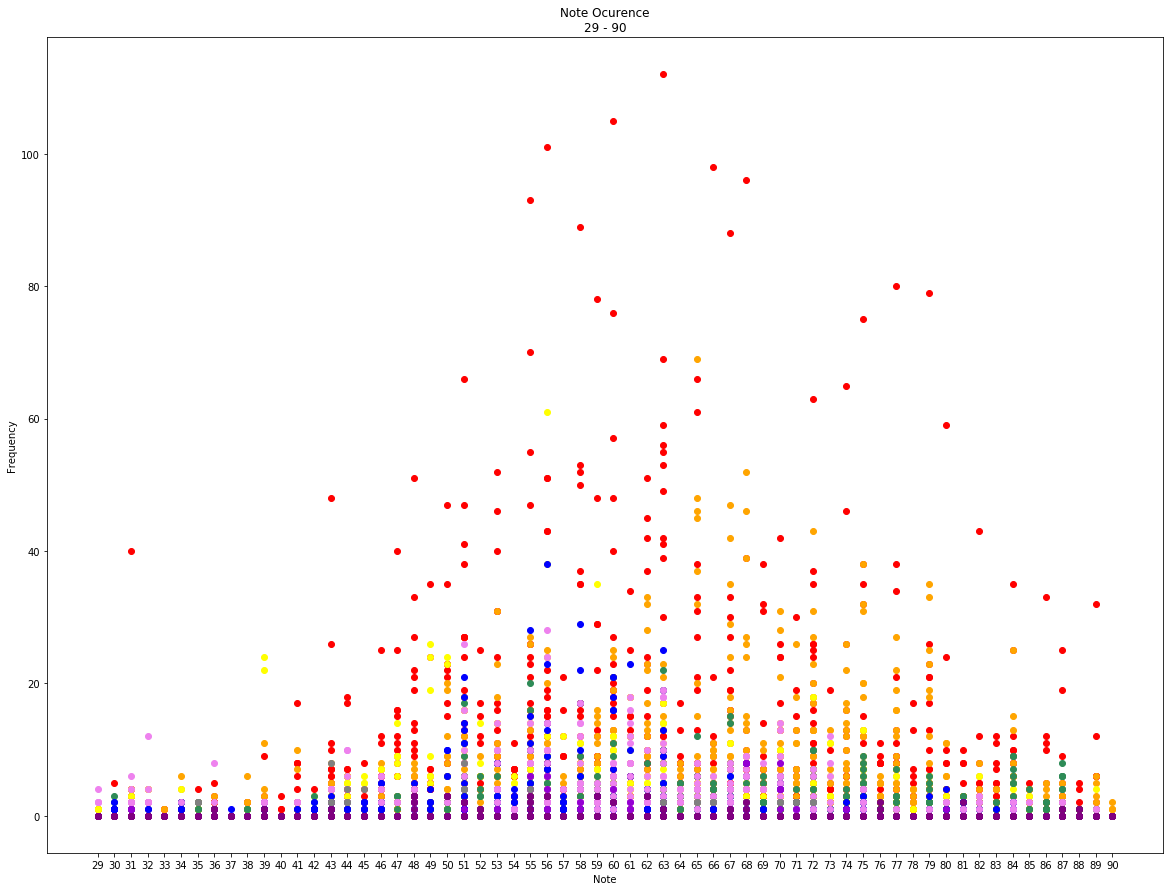

In [413]:
plt.figure(figsize = (20,15))
plt.title('Note Ocurence\n' + str(stock.index.min()) + ' - ' + str(stock.index.max()))

for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:250'.format(i)],'o',color="red")
    except KeyError:
        continue
for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:500'.format(i)],'o',color="orange") 
    except KeyError:
        continue
for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:750'.format(i)],'o',color="yellow")
    except KeyError:
        continue
for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:1000'.format(i)],'o',color="seagreen")
    except KeyError:
        continue
for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:1250'.format(i)],'o',color="blue")
    except KeyError:
        continue
for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:1500'.format(i)],'o',color="violet")
    except KeyError:
        continue
for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:2000'.format(i)],'o',color="darkviolet")
    except KeyError:
        continue
for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:4000'.format(i)],'o',color="gray")
    except KeyError:
        continue
for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:5000'.format(i)],'o',color="black")
    except KeyError:
        continue
for i in range(stock.index.min(),stock.index.max()):
    try:
        plt.plot(stock.index, stock['{}:3000'.format(i)],'o',color="purple")
    except KeyError:
        continue
        
plt.xticks(stock.index[::], stock.index[::])
plt.xlabel('Note')
plt.ylabel('Frequency')
plt.savefig('Beethovensmall.png', transparent='true')
plt.show()

In [373]:
moza = Parser('mz_330_1.mid')
Mozart = moza.markov_chain
moza = Parser('mz_330_2.mid')
Mozart2 = moza.markov_chain
moza = Parser('mz_330_3.mid')
Mozart3 = moza.markov_chain
moza = Parser('mz_545_1.mid')
Mozart4 = moza.markov_chain
moza = Parser('mz_545_2.mid')
Mozart5 = moza.markov_chain
moza = Parser('mz_545_3.mid')
Mozart6 = moza.markov_chain
moza = Parser()

In [374]:
Mozart.merge(Mozart2)
Mozart.merge(Mozart3)
Mozart.merge(Mozart4)
Mozart.merge(Mozart5)
Mozart.merge(Mozart6)


In [380]:
table2 = pd.read_csv('Mozart.csv')
table2 = table2.set_index('Note')
show2 = table2.head()
show2 = show2.append(table2.tail())
show2

,76:250,79:250,75:750,72:250,84:500,76:750,81:750,75:1250,76:500,75:250,...,45:250,47:1000,51:750,45:1000,58:1000,62:1250,61:2750,47:750,47:250,Unnamed: 261
Note,,,,,,,,,,,,,,,,,,,,,
77,116,61,4,20,2,15,6,2,29,17,...,0,0,0,0,0,0,0,0,0,NaN
74,73,42,0,110,0,8,6,0,9,4,...,0,0,0,0,0,0,0,0,0,NaN
72,37,20,6,18,0,7,5,0,16,7,...,0,0,0,0,0,0,0,0,0,NaN
71,1,8,0,58,0,8,0,0,4,0,...,0,0,0,0,0,0,0,0,0,NaN
76,20,55,2,64,8,4,0,0,16,10,...,0,0,0,0,0,0,0,0,0,NaN
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
40,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
87,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN


In [379]:
#test data
Mozart.print_as_matrix()

        76:250  79:250  75:750  72:250  84:500  76:750  81:750  75:1250 76:500  75:250  
77      116     61      4       20      2       15      6       2       29      17      
74      73      42      0       110     0       8       6       0       9       4       
72      37      20      6       18      0       7       5       0       16      7       
71      1       8       0       58      0       8       0       0       4       0       
76      20      55      2       64      8       4       0       0       16      10      
79      68      19      0       2       2       2       0       0       24      0       
75      14      0       6       3       0       4       0       0       11      6       
69      3       0       2       34      0       3       2       0       2       3       
81      4       84      0       0       4       0       0       0       0       0       
67      12      4       2       34      0       7       0       0       6       0       
84      3       21   

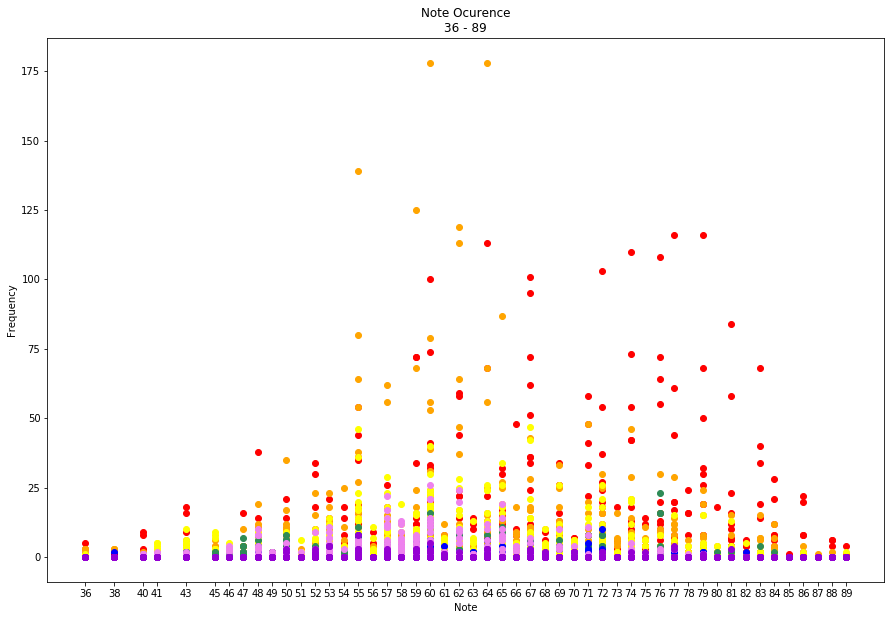

In [412]:
plt.figure(figsize = (15,10))
plt.title('Note Ocurence\n' + str(table2.index.min()) + ' - ' + str(table2.index.max()))

for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:250'.format(i)],'o',color="red")
    except KeyError:
        continue
for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:500'.format(i)],'o',color="orange") 
    except KeyError:
        continue
for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:750'.format(i)],'o',color="yellow")
    except KeyError:
        continue
for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:1000'.format(i)],'o',color="seagreen")
    except KeyError:
        continue
for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:1250'.format(i)],'o',color="blue")
    except KeyError:
        continue
for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:1500'.format(i)],'o',color="violet")
    except KeyError:
        continue
for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:2000'.format(i)],'o',color="darkviolet")
    except KeyError:
        continue
for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:4000'.format(i)],'o',color="gray")
    except KeyError:
        continue
for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:5000'.format(i)],'o',color="black")
    except KeyError:
        continue
for i in range(table2.index.min(),table2.index.max()):
    try:
        plt.plot(table2.index, table2['{}:3000'.format(i)],'o',color="purple")
    except KeyError:
        continue
        
plt.xticks(table2.index[::], table2.index[::])
plt.xlabel('Note')
plt.ylabel('Frequency')

plt.savefig('Mozartosmall.png', transparent='true')
plt.show()


In [407]:
Chopin.print_as_matrix()

        77:3000 77:6000 78:9000 73:2250 69:2250 73:500  85:500  65:4500 64:4500 73:4500 
77      2       2       3       7       3       5       1       1       1       1       
78      0       0       0       3       3       4       3       0       0       0       
76      5       1       0       0       0       9       3       0       0       0       
74      0       0       0       0       0       7       5       0       0       0       
73      0       0       0       0       0       22      11      3       2       4       
72      2       0       0       0       0       12      2       0       0       0       
80      0       0       0       0       0       7       3       0       0       0       
85      0       0       0       0       0       10      9       0       0       0       
75      1       0       0       0       0       9       1       0       0       0       
68      1       0       0       3       0       7       0       0       0       0       
71      3       0    

In [408]:
chain = Mozart
Generator.load(chain).generate("Mozart Generated")
print('Generated markov chain')

Generated markov chain
